In [1]:
import numpy as np
import pandas as pd
import math
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import joblib

In [2]:
# 导入数据，设置列名
def readDatasets(train_path, validation_path, test_path):
    prsa_train = pd.read_csv(train_path)
    prsa_val = pd.read_csv(validation_path)
    prsa_test = pd.read_csv(test_path)
    return prsa_train, prsa_val, prsa_test

In [3]:
prsa_train, prsa_val, prsa_test = readDatasets('PRSA_train.data.csv', 'PRSA_validation.data.csv', 'PRSA_test.data.csv')
# 删除第0列（id无法提供有效信息）
prsa_train, prsa_val, prsa_test = prsa_train.drop('No', axis=1), prsa_val.drop('No', axis=1), prsa_test.drop('No', axis=1)
# 构造完整数据集
prsa_full = pd.concat([prsa_train, prsa_val, prsa_test])
prsa_full = prsa_full.reset_index(drop=True)
# 把pm2.5列换到最前面，方便使用
prsa_full_pm25 = prsa_full['pm2.5']
prsa_full = prsa_full.drop('pm2.5', axis=1)
prsa_full.insert(0, 'pm2.5', prsa_full_pm25)

### 一、数据预处理+特征工程

#### 0. 缺失值处理+属性值编码 
把三个数据集合并，统一进行缺失值处理和离散属性编码。

In [4]:
# 用每个月的平均值填充月份为该月的pm2.5缺失值
for i in range(1,13):
    temp_pm25_mean = round(prsa_full[prsa_full['month'] == i]['pm2.5'].mean())
    temp_idx = prsa_full[(prsa_full['month'] == i) & (prsa_full['pm2.5'].isnull())].index.tolist()
    prsa_full.iloc[temp_idx, 0] = prsa_full.iloc[temp_idx, 0].fillna(temp_pm25_mean)

In [5]:
labelencoder = LabelEncoder()
onehotencoder = OneHotEncoder()
prsa_full = prsa_full.join(pd.get_dummies(prsa_full['cbwd']))
prsa_full = prsa_full.drop('cbwd', axis=1)
prsa_full['year'] = labelencoder.fit_transform(prsa_full['year'])
prsa_full['month'] = labelencoder.fit_transform(prsa_full['month'])
prsa_full['day'] = labelencoder.fit_transform(prsa_full['day'])
prsa_full

,pm2.5,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
0,129.0,2,9,6,4,9,10.0,1024.0,0.89,0,0,0,1,0,0
1,13.0,4,9,11,20,-1,13.0,1030.0,29.96,0,0,0,1,0,0
2,16.0,3,5,16,13,16,29.0,1001.0,1.79,0,0,0,0,1,0
3,42.0,4,6,13,18,15,35.0,1001.0,19.67,0,0,0,0,1,0
4,32.0,1,9,2,3,2,4.0,1030.0,7.60,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,92.0,3,6,21,3,20,22.0,1005.0,28.14,0,0,0,0,1,0
43820,78.0,3,5,12,17,12,30.0,1006.0,29.95,0,0,0,0,1,0
43821,472.0,4,9,24,20,14,15.0,1012.0,2.68,0,0,0,0,1,0
43822,80.0,2,7,17,17,24,25.0,1006.0,1.79,0,3,1,0,0,0


##### 1. 根据特征的实际意义进行深层语义的特征构建

In [6]:
# 季度属性
prsa_full['quarter'] = 1 + ((prsa_full['month']) / 3)
prsa_full['quarter'] = prsa_full['quarter'].apply(math.floor)
prsa_full_quarter = prsa_full['quarter']
prsa_full = prsa_full.drop('quarter', axis=1)
prsa_full.insert(2, 'quarter', prsa_full_quarter)

##### 2. 聚类属性

In [7]:
from sklearn.cluster import KMeans
# 选择参与聚类的特征
features = ['pm2.5','DEWP','Iws','PRES','TEMP','month','quarter']
# 标准化
X_scaled = prsa_full.loc[:, features[:5]]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
# 生成kmeans模型
kmeans = KMeans(n_clusters=20, random_state=0)
# 生成类别特征
prsa_full["Cluster"] = kmeans.fit_predict(pd.concat([prsa_full[features[5:]], X_scaled], axis=1))
# X_cd存放每个样本到各聚类中心的距离
X_cd = kmeans.fit_transform(pd.concat([prsa_full[features[5:]], X_scaled], axis=1))
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
prsa_full = prsa_full.join(X_cd)
prsa_full

,pm2.5,year,quarter,month,day,hour,DEWP,TEMP,PRES,Iws,...,Centroid_10,Centroid_11,Centroid_12,Centroid_13,Centroid_14,Centroid_15,Centroid_16,Centroid_17,Centroid_18,Centroid_19
0,129.0,2,4,9,6,4,9,10.0,1024.0,0.89,...,6.894765,5.021142,7.248184,3.891536,1.765283,0.939860,6.443485,3.862717,10.550193,7.609183
1,13.0,4,4,9,11,20,-1,13.0,1030.0,29.96,...,6.149272,5.393884,6.936942,4.701253,3.278251,1.102056,6.470777,2.999295,10.116238,7.964671
2,16.0,3,2,5,16,13,16,29.0,1001.0,1.79,...,9.552457,1.043876,4.462437,2.540307,5.495345,5.158206,3.110012,7.526560,8.223385,4.463578
3,42.0,4,3,6,13,18,15,35.0,1001.0,19.67,...,8.728604,1.810770,4.948032,1.833611,4.545866,4.227993,4.073278,6.651041,8.933423,5.471602
4,32.0,1,4,9,2,3,2,4.0,1030.0,7.60,...,6.526168,5.487226,7.197370,4.778386,3.129711,1.164639,6.507107,3.299650,10.265977,7.893892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,92.0,3,3,6,21,3,20,22.0,1005.0,28.14,...,8.335571,1.498667,4.684974,1.163350,3.891469,3.811470,3.736697,6.265915,8.527854,4.962624
43820,78.0,3,2,5,12,17,12,30.0,1006.0,29.95,...,9.035882,0.680230,3.878134,2.173661,5.083858,4.953892,2.775752,7.167398,7.687315,4.026894
43821,472.0,4,4,9,24,20,14,15.0,1012.0,2.68,...,8.611846,6.227063,8.644464,4.544015,2.327125,4.710755,7.841042,6.535422,11.836998,8.058176
43822,80.0,2,3,7,17,17,24,25.0,1006.0,1.79,...,8.354700,2.318072,5.732665,1.365322,3.356335,3.210579,4.697079,5.990953,9.564594,5.918270


In [ ]:
# # 先画前3个图
# sns.relplot(
#     x="value", y="pm2.5", hue="Cluster", col="variable",
#     height=4, aspect=1, facet_kws={'sharex': False}, palette='muted',
#     data=prsa_full.melt(
#         value_vars=features[1:4],
#         id_vars=["pm2.5", "Cluster"]
#     )
# )

# # 再画后3个图
# sns.relplot(
#     x="value", y="pm2.5", hue="Cluster", col="variable",
#     height=4, aspect=1, facet_kws={'sharex': False}, palette='muted',
#     data=prsa_full.melt(
#         value_vars=features[4:],
#         id_vars=["pm2.5", "Cluster"]
#     )
# )

#### 3. 互信息

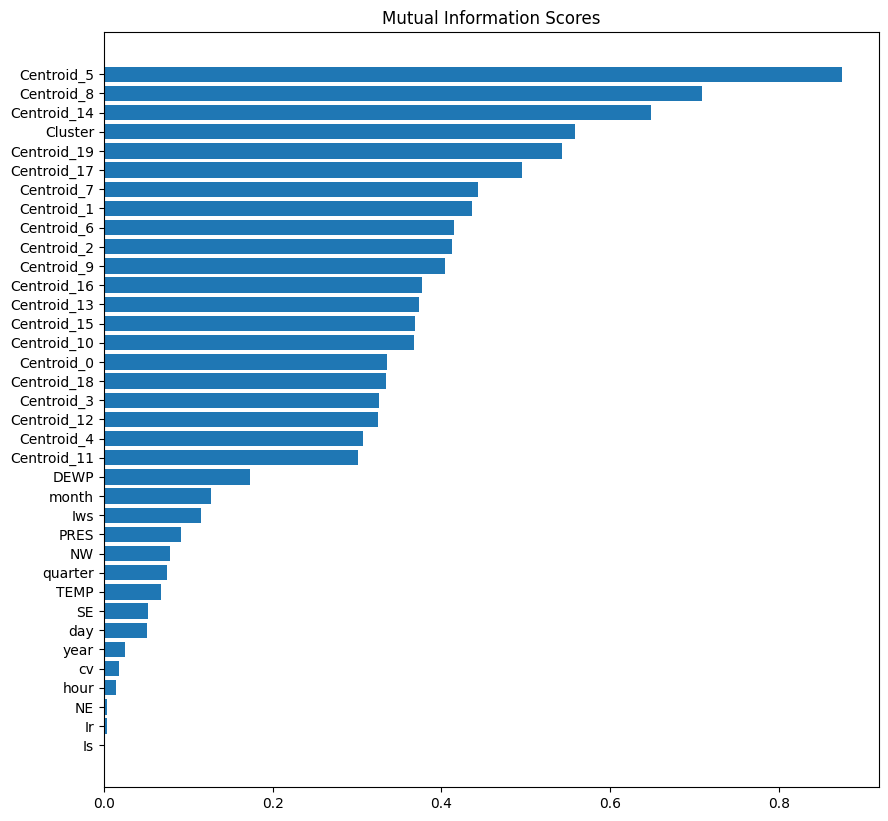

In [8]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# 计算所有特征与price之间的互信息，降序排列。互信息能捕捉任何相关性，不适用于稀疏矩阵
def make_mi_scores(X, y, features):
    mi_scores = mutual_info_regression(X, y, discrete_features=features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# 互信息值降序排列可视化
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# # 计算训练集特征和price间的互信息
mi_scores = make_mi_scores(prsa_full.iloc[:,1:], prsa_full.iloc[:,0], 'auto')
plt.figure(dpi=100, figsize=(10, 10))
plot_mi_scores(mi_scores)

#### 4. scatterplot

<AxesSubplot:xlabel='NE', ylabel='pm2.5'>

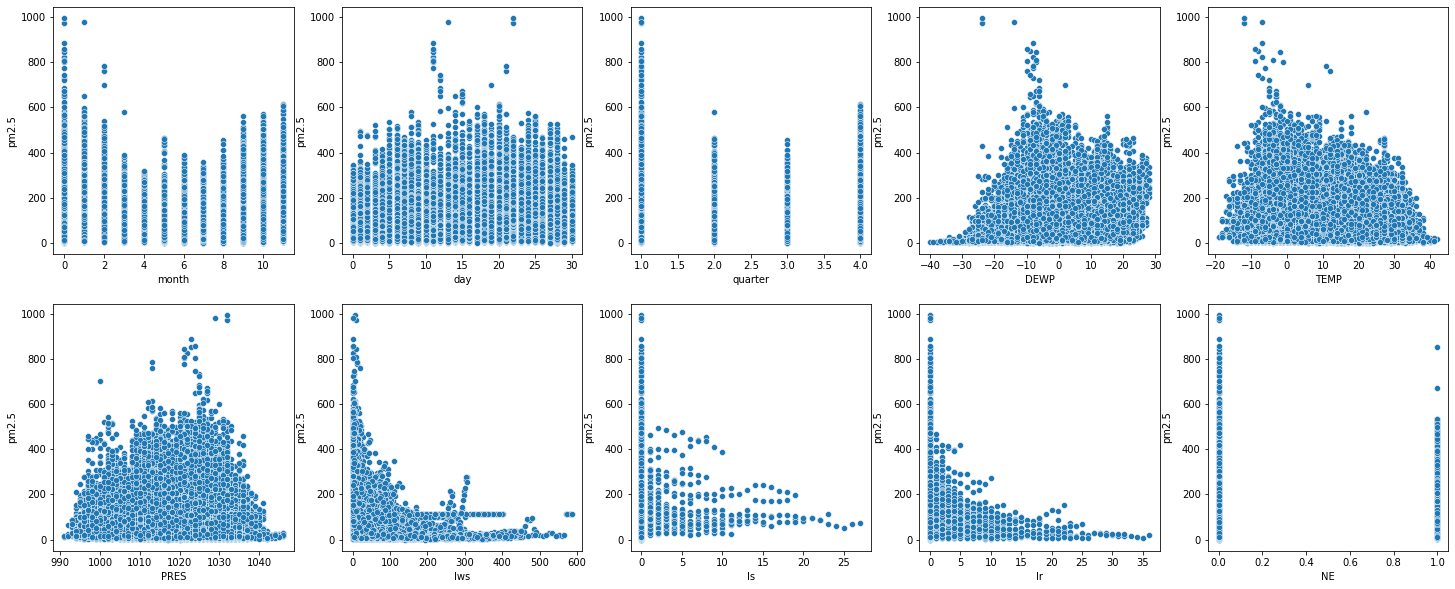

In [9]:
# 绘制若干重要特征和pm2.5之间的散点图
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax_arr = plt.subplots(2,5, figsize=(25,10))
sns.scatterplot(x="month", y="pm2.5", data=prsa_full, ax=ax_arr[0][0])
sns.scatterplot(x="day", y="pm2.5", data=prsa_full, ax= ax_arr[0][1])
sns.scatterplot(x="quarter", y="pm2.5", data=prsa_full, ax=ax_arr[0][2])
sns.scatterplot(x="DEWP", y="pm2.5", data=prsa_full, ax=ax_arr[0][3])
sns.scatterplot(x="TEMP", y="pm2.5", data=prsa_full, ax=ax_arr[0][4])
sns.scatterplot(x="PRES", y="pm2.5", data=prsa_full, ax=ax_arr[1][0])
sns.scatterplot(x="Iws", y="pm2.5", data=prsa_full, ax=ax_arr[1][1])
sns.scatterplot(x="Is", y="pm2.5", data=prsa_full, ax=ax_arr[1][2])
sns.scatterplot(x="Ir", y="pm2.5", data=prsa_full, ax=ax_arr[1][3])
sns.scatterplot(x="NE", y="pm2.5", data=prsa_full, ax=ax_arr[1][4])

#### 5. 对数变换纠正偏度（属性+pm2.5因变量）

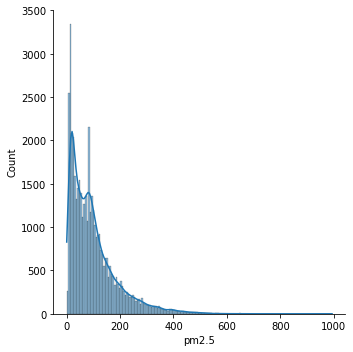

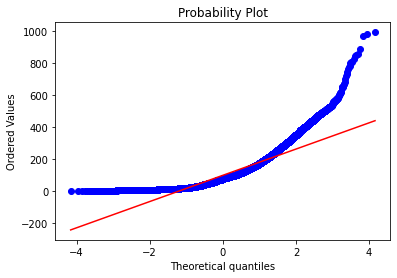

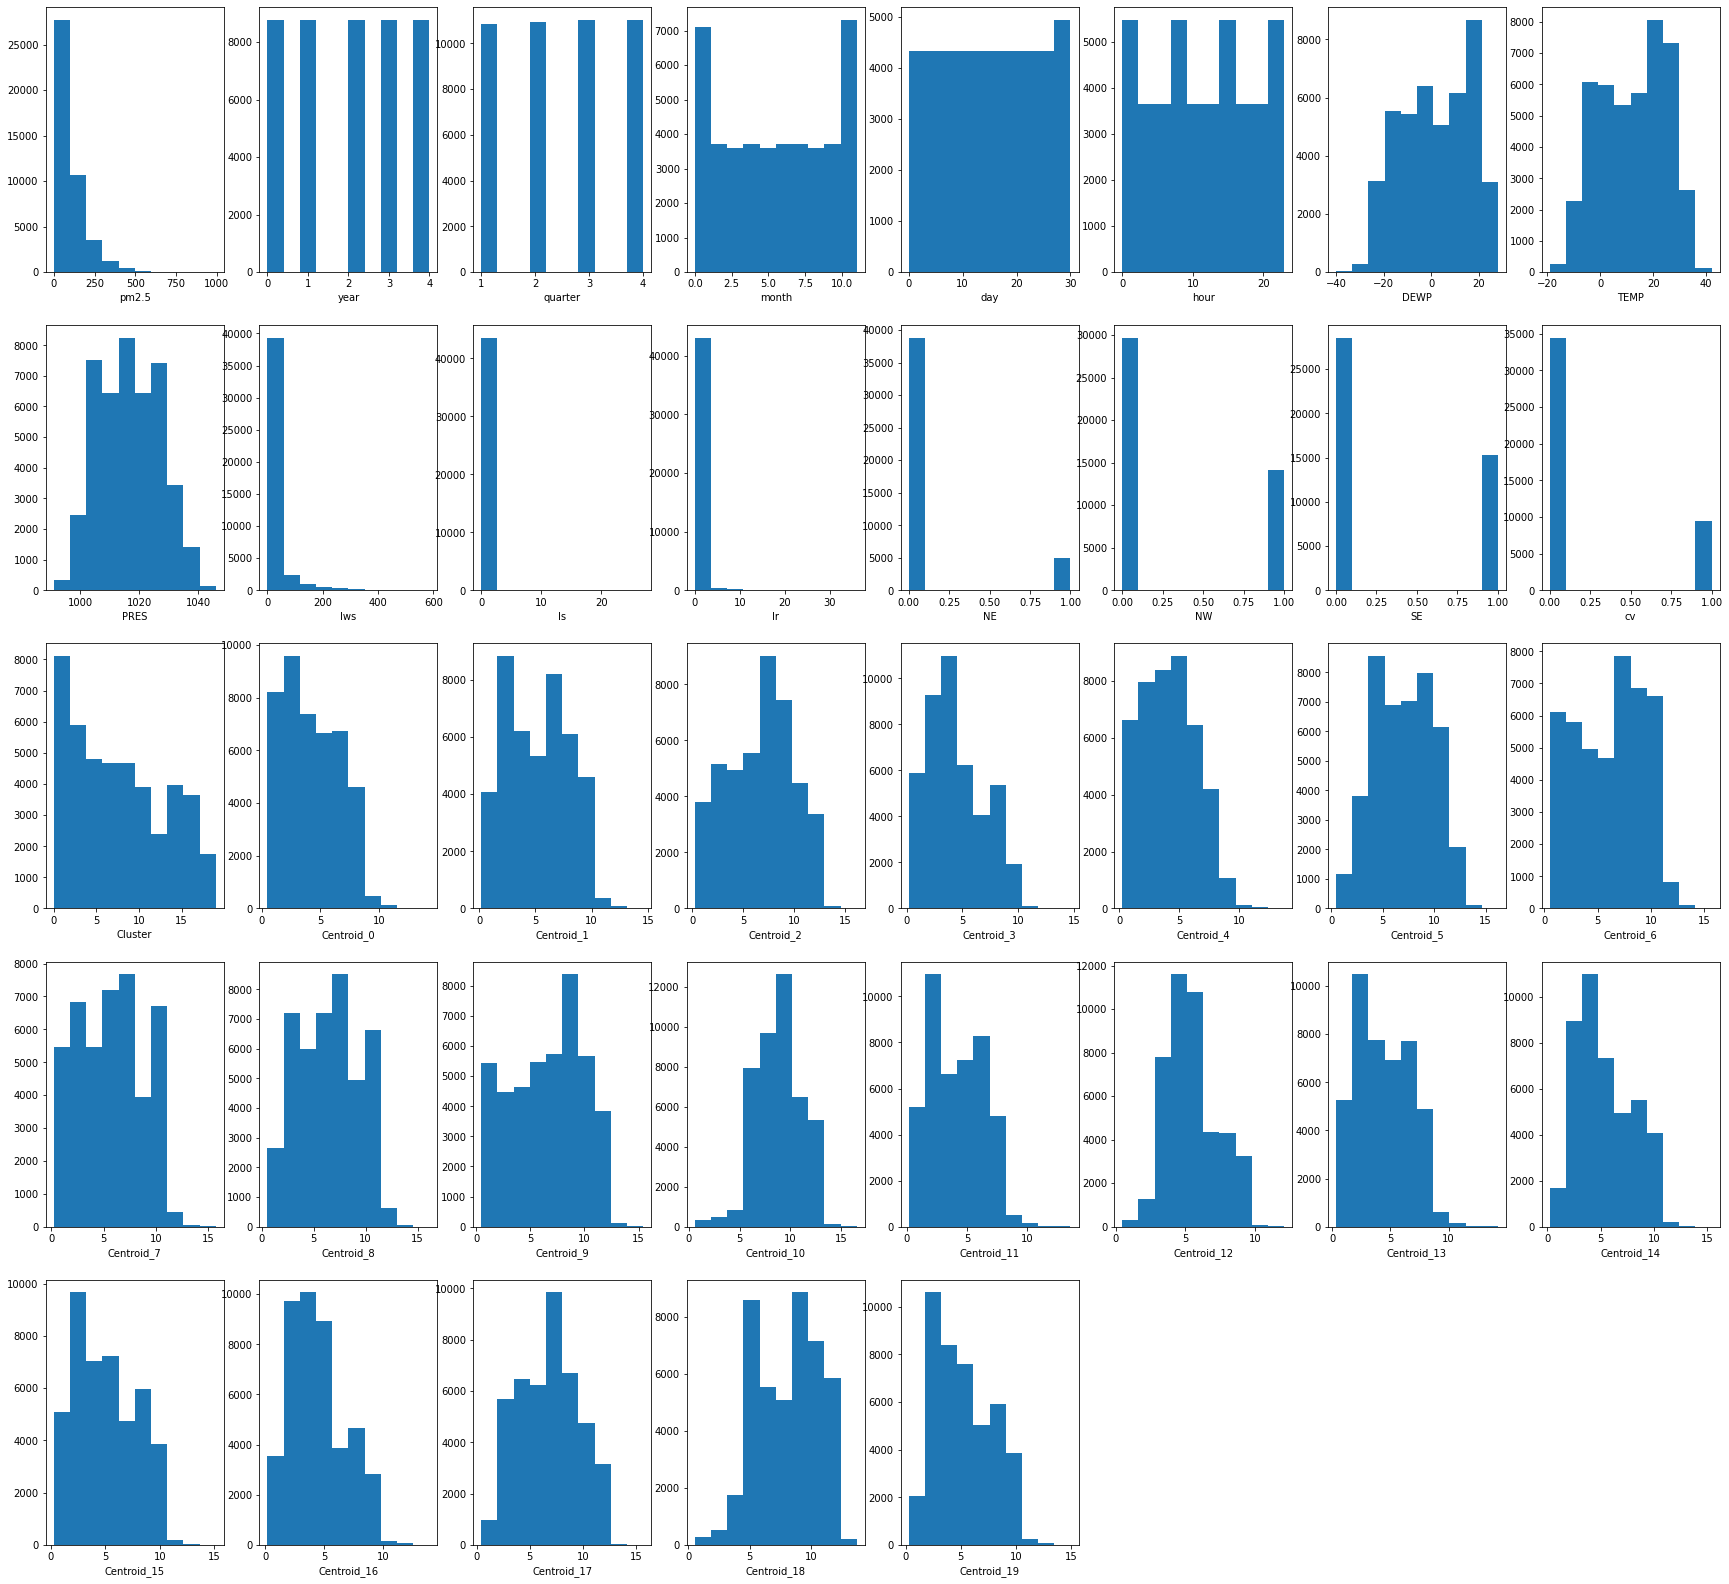

In [10]:
# 绘制pm2.5分布+偏度图
sns.displot(prsa_full['pm2.5'], kde=True)
fig = plt.figure()
res = scipy.stats.probplot(prsa_full['pm2.5'], plot=plt)

fig = plt.figure(figsize=(30, 40))
cols = prsa_full.columns.to_list()
for col in cols:
    ax = fig.add_subplot(7, 8, cols.index(col)+1)
    ax.set_xlabel(col)
    ax.hist(prsa_full[col])

pm2.5           1.849541
year            0.000000
quarter        -0.011353
month          -0.009527
day             0.006912
hour            0.000000
DEWP           -0.152447
TEMP           -0.163304
PRES            0.098207
Iws             4.297893
Is             19.483592
Ir             11.662153
NE              2.428820
NW              0.757621
SE              0.634087
cv              1.393306
Cluster         0.320765
Centroid_0      0.251377
Centroid_1      0.130675
Centroid_2     -0.196902
Centroid_3      0.481939
Centroid_4      0.396193
Centroid_5     -0.046693
Centroid_6     -0.093411
Centroid_7      0.085857
Centroid_8      0.024143
Centroid_9     -0.236181
Centroid_10    -0.241093
Centroid_11     0.226372
Centroid_12     0.409544
Centroid_13     0.268658
Centroid_14     0.438140
Centroid_15     0.351845
Centroid_16     0.461152
Centroid_17    -0.021866
Centroid_18    -0.224090
Centroid_19     0.399583
dtype: float64
对数变换后的偏度： pm2.5   -0.359883
Iws      0.704742
dtype: float64

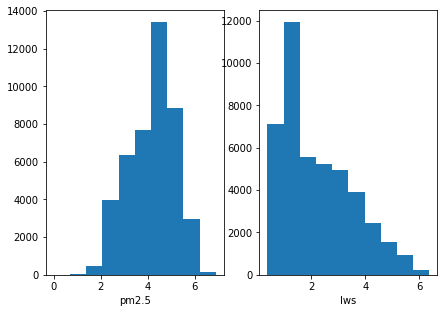

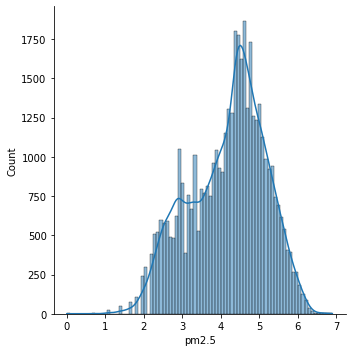

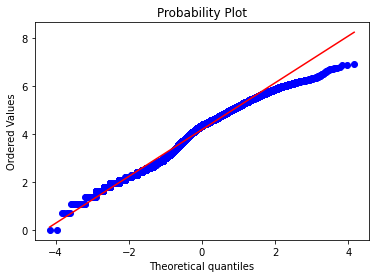

In [11]:
# 对数变换
skews = prsa_full[cols].skew()
print(skews)
cols_need_log1p = ['pm2.5', 'Iws']
for col in cols_need_log1p:
        prsa_full[col] = np.log1p(prsa_full[col])

# 绘制变换后的直方图
fig = plt.figure(figsize=(30, 40))
for col in cols_need_log1p:
    ax = fig.add_subplot(7, 8, cols_need_log1p.index(col)+1)
    ax.set_xlabel(col)
    ax.hist(prsa_full[col])

# 计算变换后各数值型特征的偏度
skews = prsa_full[cols_need_log1p].skew()
print('对数变换后的偏度：',skews)
# 绘制pm2.5分布即偏度图
sns.displot(prsa_full['pm2.5'], kde= True)
fig = plt.figure()
res = scipy.stats.probplot(prsa_full['pm2.5'], plot=plt)

### 二、构造属性集、标签向量

In [12]:
# 构造全体数据
X_full = prsa_full.iloc[:, 1:]
y_full = prsa_full.iloc[:, 0]
# 构造训练集、验证集和测试集
X_train, y_train = prsa_full.iloc[:26294, 1:], prsa_full.iloc[:26294, 0]
X_val, y_val = prsa_full.iloc[26294:35059, 1:], prsa_full.iloc[26294:35059, 0]
X_test, y_test = prsa_full.iloc[35059:, 1:], prsa_full.iloc[35059:, 0]
# 标准化，用于SVM
features = ['DEWP','Iws','PRES','TEMP','Is','Ir','month','quarter','year','NE','NW','SE','cv','Cluster',
            'Centroid_0','Centroid_1','Centroid_2','Centroid_3','Centroid_4','Centroid_5','Centroid_6',
            'Centroid_7','Centroid_8','Centroid_9','Centroid_10','Centroid_11','Centroid_12','Centroid_13','Centroid_14']
X_scaled = prsa_full.loc[:, features[:4]]
X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
prsa_full_scaled = pd.concat([prsa_full[features[4:]], X_scaled], axis=1)
X_train_scaled = prsa_full_scaled[:26294]
X_val_scaled = prsa_full_scaled[26294:35059]
X_test_scaled = prsa_full_scaled[35059:]

### 三、多模型调参

In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import RobustScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

In [14]:
# 定义交叉验证模式
kf = KFold(n_splits=5, random_state=0, shuffle=True)

# 定义交叉验证误差
def cv_mse(model):
    return -1 * cross_val_score(model, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]), scoring='neg_mean_squared_error', cv=kf)

# 定义svr的交叉验证误差
def cv_mse_svr(model):
    return -1 * cross_val_score(model, pd.concat([X_train_scaled, X_val_scaled]), pd.concat([y_train, y_val]), scoring='neg_mean_squared_error', cv=kf)

# 定义均方根误差计算函数
def calc_mse(y_pred, y_true):
    return mean_squared_error(y_pred, y_true)

# 实例化基模型
model_svr = make_pipeline(RobustScaler(), SVR(C=15, epsilon= 0.0006, gamma=0.00045))
model_dt = DecisionTreeRegressor()
model_rf = RandomForestRegressor(n_estimators=1000)
model_gbr = GradientBoostingRegressor(n_estimators=500,
                                      learning_rate=0.01,
                                      max_depth=5,
                                      max_features='sqrt',
                                      min_samples_leaf=15,
                                      min_samples_split=10,
                                      loss='huber',
                                      random_state=0)
model_xgb = XGBRegressor(n_estimators=500,
                         learning_rate=0.01,
                         max_depth=5,
                         random_state=0)
model_lgb = LGBMRegressor(objective='regression',
                          n_estimators=500,
                          learning_rate = 0.01,
                          max_depth=5,
                          num_leaves=30,
                          min_data_in_leaf=3,
                          max_bin=25,
                          bagging_fraction=0.6,
                          bagging_freq=11,
                          feature_fraction=0.6,
                          verbose=-1,
                          n_jobs=-1,
                          random_state=0)

models = [model_svr, model_dt, model_rf, model_gbr, model_xgb, model_lgb]
model_names = ['svr','dt','rf','gbr','xgb','lgb']

In [ ]:
# # 基线模型评估
# scores = {}
# for i, model in enumerate(models):
#     if model == model_svr:
#         score = cv_mse_svr(model)
#     else:
#         score = cv_mse(model)
#     print('{} mse score: {:.4f}, mse std: {:.4f}'.format(model_names[i], score.mean(), score.std()))
#     scores[model_names[i]] = (score.mean(), score.std())

### 四、多模型融合

In [ ]:
# models = [model_dt, model_rf, model_gbr, model_xgb, model_lgb]

# # 计算各模型的预测结果
# def calc_preds(models, X_val):
#     # preds存放各模型的预测结果
#     preds = []
#     for model in models:
#         model.fit(X_train, y_train)
#         model_pred = model.predict(X_val)
#         preds.append(model_pred)
#     # 计算总预测值
#     return preds

# # 计算blending结果
# def calc_blending_pred(preds, weights):
#     blending_pred = 0.0
#     for pred, weight in zip(preds, weights):
#         blending_pred += pred * weight
#     return blending_pred

# # 衡量验证集的blending误差
# weights = [0.05, 0.8, 0.05, 0.05, 0.05]
# val_preds = calc_preds(models, X_val)
# val_blending_mse = calc_mse(y_val, calc_blending_pred(val_preds, weights))
# print(val_blending_mse)

求验证集MSE

In [15]:
# model_rf.fit(X_train, y_train)
# 保存模型
# joblib.dump(model_rf, "model_rf1.pth")
model_rf = joblib.load("model_rf.pth")
rf_val_pred = model_rf.predict(X_val)
rf_val_mse = calc_mse(y_val, rf_val_pred)
print(rf_val_mse)   # 0.02222 n=1000

C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.02222408034833288


#### 五、预测测试集

In [16]:
model_rf = joblib.load("model_rf.pth")
rf_test_pred = model_rf.predict(X_test)
rf_test_mse = calc_mse(y_test, rf_test_pred)
print(rf_test_mse)  # 0.02428 n=1000

C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\HP\AppData\Roaming\Python\Python36\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0.024289418756141927


In [17]:
# 输出还原数据尺度的MSE
print('最终MSE：', calc_mse((np.exp(y_test) - 1), np.exp(rf_test_pred) - 1))
final_pred = np.exp(rf_test_pred) - 1
test_output = pd.DataFrame({'pm2.5': final_pred})
test_output.to_csv('pred_result.csv', index=False)

最终MSE： 264.73532727131493
